# Advanced Artificial Intelligence William Forber 22015706:

### Imports and splitting features into different categories like numerical, categorical and redundant:

In [1]:
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
import pandas as pd
import tensorflow as tf
import keras
import keras_tuner as kt
from keras import layers
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

K = 5
test_results = []
k_fold = KFold(n_splits=K, shuffle=True, random_state=42)

dataset = pd.read_csv('../Dataset/Synthetic_Data_For_Students.csv')
dataset.head(10)
tf.config.list_physical_devices('GPU')

redundant_labels = ['AccidentType','Accident Description', 'Claim Date', 'Accident Date',
                    'SpecialHealthExpenses', 'SpecialReduction', 'SpecialOverage', 'GeneralRest',
                    'SpecialAdditionalInjury', 'SpecialEarningsLoss', 'SpecialUsageLoss', 'SpecialMedications',
                    'SpecialAssetDamage', 'SpecialRehabilitation', 'SpecialFixes', 'GeneralFixed', 'GeneralUplift',
                    'SpecialLoanerVehicle', 'SpecialTripCosts', 'SpecialJourneyExpenses', 'SpecialTherapy', 'Dominant injury']

category_labels = [ 'Exceptional_Circumstances', 'Minor_Psychological_Injury',
                   'Whiplash', 'Vehicle Type', 'Weather Conditions',
                   'Police Report Filed', 'Witness Present', 'Gender', 'Injury Description']

numerical_labels = ['SettlementValue', 'Injury_Prognosis',
                    'Vehicle Age', 'Driver Age', 'Number of Passengers']

### Functions for Pre-Processing Dataset - Removal of redundant features and null values, scaling and categorisation:

In [2]:
def clean_dataset(data):
    data.dropna(inplace=True)
    data.drop(redundant_labels, axis=1, inplace=True)
    return data


def categorise_data(data, label):
    values = data[label].astype(str).str.lower()

    if values.nunique() == 2 and set(values.unique()) <= {'yes', 'no'}:
        # Binary yes/no → boolean
        data[label] = values.map({'yes': True, 'no': False})
    
    elif values.nunique() <= 5:
        # Small number of categories → label encode
        data[label], _ = pd.factorize(data[label])
    
    else:
        # High cardinality → one-hot encode with prefix
        categories = pd.get_dummies(data[label], prefix=label)
        data.drop(label, axis=1, inplace=True)
        data = pd.concat([data, categories], axis=1)

    return data



def extract_months(prognosis):
    return int(''.join(filter(str.isdigit, prognosis)))


def scale_data(data):
    scaler = RobustScaler()
    data[numerical_labels] = scaler.fit_transform(data[numerical_labels])
    return data, scaler


def preprocess_data(data):
    data = clean_dataset(data)
    data['Injury_Prognosis'] = data['Injury_Prognosis'].apply(extract_months)
    data, scaler = scale_data(data)
    for label in category_labels:
        data = categorise_data(data, label)

    # outlier removal
    upper_limit = data['SettlementValue'].quantile(0.90)
    lower_limit = data['SettlementValue'].quantile(0.10)

    data['SettlementValue'] = data['SettlementValue'].clip(
        lower=lower_limit, upper=upper_limit)

    return data, scaler

### Defining the Control Model:

In [3]:
def base_model(X_train_tf):
    model = keras.Sequential([
        layers.Dense(128, activation='relu', input_shape=(
            X_train_tf.shape[1],)),
        layers.Dropout(0.2),
        layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mae', metrics=['mae'])
    return model


### Defining the Tunable Model Based on the Control Model:

In [4]:
def build_model(hp, input_shape):
    model = keras.Sequential()

    # First layer activation handling
    activation_name = hp.Choice('activation_1', ['relu', 'tanh', 'leaky_relu'])
    activation = layers.LeakyReLU() if activation_name == 'leaky_relu' else activation_name

    model.add(layers.Dense(hp.Int('units_1', 32, 128, step=32),
                           activation=activation,
                           kernel_regularizer=tf.keras.regularizers.l2(
                               hp.Float('l2_reg', 1e-5, 1e-2, sampling='log')),
                           input_shape=(input_shape,)))

    if hp.Boolean('batch_norm'):
        model.add(layers.BatchNormalization())

    model.add(layers.Dropout(hp.Float('dropout_1', 0.1, 0.4, step=0.05)))
    
    model.add(layers.Dense(1))

    # Huber loss delta
    delta_value = hp.Float('huber_delta', 0.5, 5.0, step=0.5)

    model.compile(
        optimizer=keras.optimizers.Adam(
            learning_rate=hp.Choice('learning_rate', [0.01, 0.001, 0.0001])),
        loss=tf.keras.losses.Huber(delta=delta_value),
        metrics=['mae']
    )

    return model

### Defining a function to evaluate the models using K-Fold-Cross-Validation:

In [5]:
def evaluate_model(model, X_test_tf, y_test_tf, scaler):
    y_pred_tf = model.predict(X_test_tf)
    y_pred_np = y_pred_tf.flatten()
    y_test_np = y_test_tf.numpy().flatten()

    # Find the index of 'SettlementValue' in numerical_labels to get the correct scale factor
    settlement_value_index = numerical_labels.index('SettlementValue')

    # Inverse scale the predictions and true values to the original scale
    y_pred_unscaled = y_pred_np * scaler.scale_[settlement_value_index]
    y_test_unscaled = y_test_np * scaler.scale_[settlement_value_index]

    test_mae = np.mean(
        np.abs(y_pred_unscaled - y_test_unscaled))  # Unscaled MAE
    test_r2 = r2_score(y_test_unscaled, y_pred_unscaled)

    return test_mae, test_r2, y_test_unscaled, y_pred_unscaled


def cross_validate_model(model_builder, X_np, y_np, k_fold, scaler):
    fold_mae_scores = []
    fold_r2_scores = []
    actual_values = []
    predicted_values = []

    for fold_num, (train_index, test_index) in enumerate(k_fold.split(X_np), start=1):
        print(f"Processing fold {fold_num}/{k_fold.get_n_splits()}")
        X_train_fold, X_test_fold = X_np[train_index], X_np[test_index]
        y_train_fold, y_test_fold = y_np[train_index], y_np[test_index]

        X_train_tf = tf.convert_to_tensor(X_train_fold, dtype=tf.float32)
        X_test_tf = tf.convert_to_tensor(X_test_fold, dtype=tf.float32)
        y_train_tf = tf.convert_to_tensor(y_train_fold, dtype=tf.float32)
        y_test_tf = tf.convert_to_tensor(y_test_fold, dtype=tf.float32)

        model = model_builder(X_train_tf)

        early_stopping = EarlyStopping(
            monitor='val_mae',
            patience=10,
            restore_best_weights=True,
            verbose=1
        )

        model.fit(
            X_train_tf, y_train_tf,
            epochs=50,
            batch_size=32,
            validation_data=(X_test_tf, y_test_tf),
            callbacks=[early_stopping]
        )

        fold_mae, fold_r2, y_actual, y_pred = evaluate_model(
            model, X_test_tf, y_test_tf, scaler)
        fold_mae_scores.append(fold_mae)
        fold_r2_scores.append(fold_r2)

        actual_values.extend(y_actual)
        predicted_values.extend(y_pred)

    average_mae = np.mean(fold_mae_scores)
    average_r2 = np.mean(fold_r2_scores)

    print(f'Average MAE across {k_fold.get_n_splits()} folds: {average_mae}')
    print(
        f'Average R² Score across {k_fold.get_n_splits()} folds: {average_r2}')

    return average_mae, average_r2, actual_values, predicted_values

### Defining the Function to Plot the Models Predicted Values against the Actual Values from the Testing Dataset:

In [6]:
def plot_predicted_vs_actual(y_actual, y_predicted, title="Predicted vs Actual Settlement Values"):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_actual, y=y_predicted, alpha=0.6)

    # Plot the perfect prediction line (y = x)
    plt.plot([min(y_actual), max(y_actual)], [min(y_actual),
             max(y_actual)], color='red', linestyle='--')

    plt.xlabel("Actual Settlement Values")
    plt.ylabel("Predicted Settlement Values")
    plt.title(title)
    plt.show()

### Results From Pre-Processing the Dataset:

In [7]:
dataset, scaler = preprocess_data(dataset)
dataset.head(5)

,SettlementValue,Injury_Prognosis,Exceptional_Circumstances,Minor_Psychological_Injury,Whiplash,Vehicle Type,Weather Conditions,Vehicle Age,Driver Age,Number of Passengers,Injury Description,Police Report Filed,Witness Present,Gender
0,-0.557143,-0.333333,False,True,True,0,0,0.272727,-0.516129,1.0,0,True,True,0
1,-0.140476,-1.333333,False,True,True,0,1,-0.545455,-0.129032,0.0,1,True,True,1
2,1.371429,0.333333,False,False,True,0,2,-0.090909,-0.129032,1.0,0,True,False,1
3,-0.557143,-0.666667,False,True,True,1,0,-0.454545,0.419355,-0.5,1,True,True,1
4,-0.586905,-1.000000,False,True,False,0,0,-0.090909,0.935484,-0.5,2,True,True,2


### Evaluating the Base Model:

In [9]:
X = dataset.drop('SettlementValue', axis=1)
y = dataset['SettlementValue']

X_np = X.values
y_np = y.values

print("Base model results: No hyperparameter tuning:")
base_mae, base_r2, base_actual, base_predicted = cross_validate_model(
    base_model, X_np, y_np, k_fold, scaler)

Base model results: No hyperparameter tuning:
Processing fold 1/5
Epoch 1/50


C:\Users\William Forber\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5428 - mae: 0.5428 - val_loss: 0.4112 - val_mae: 0.4112
Epoch 2/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4491 - mae: 0.4491 - val_loss: 0.4065 - val_mae: 0.4065
Epoch 3/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4484 - mae: 0.4484 - val_loss: 0.4080 - val_mae: 0.4080
Epoch 4/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4450 - mae: 0.4450 - val_loss: 0.4021 - val_mae: 0.4021
Epoch 5/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4359 - mae: 0.4359 - val_loss: 0.4002 - val_mae: 0.4002
Epoch 6/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4293 - mae: 0.4293 - val_loss: 0.4042 - val_mae: 0.4042
Epoch 7/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4334 - mae: 0.4334 - val_loss: 0.3999 - val_mae: 0.3999
Epoch 8/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4101 - mae: 0.4101 - val_loss: 0.4004 - val_mae: 0.4004
Epoch 9/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4238 - mae: 0.4238 - va

C:\Users\William Forber\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5330 - mae: 0.5330 - val_loss: 0.4438 - val_mae: 0.4438
Epoch 2/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4416 - mae: 0.4416 - val_loss: 0.4359 - val_mae: 0.4359
Epoch 3/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4357 - mae: 0.4357 - val_loss: 0.4374 - val_mae: 0.4374
Epoch 4/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4334 - mae: 0.4334 - val_loss: 0.4358 - val_mae: 0.4358
Epoch 5/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4227 - mae: 0.4227 - val_loss: 0.4356 - val_mae: 0.4356
Epoch 6/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4283 - mae: 0.4283 - val_loss: 0.4364 - val_mae: 0.4364
Epoch 7/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4158 - mae: 0.4158 - val_loss: 0.4369 - val_mae: 0.4369
Epoch 8/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4070 - mae: 0.4070 - val_loss: 0.4357 - val_mae: 0.4357
Epoch 9/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4179 - mae: 0.4179 - va

C:\Users\William Forber\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5626 - mae: 0.5626 - val_loss: 0.4169 - val_mae: 0.4169
Epoch 2/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4563 - mae: 0.4563 - val_loss: 0.4135 - val_mae: 0.4135
Epoch 3/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4458 - mae: 0.4458 - val_loss: 0.4169 - val_mae: 0.4169
Epoch 4/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4460 - mae: 0.4460 - val_loss: 0.4191 - val_mae: 0.4191
Epoch 5/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4298 - mae: 0.4298 - val_loss: 0.4158 - val_mae: 0.4158
Epoch 6/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4298 - mae: 0.4298 - val_loss: 0.4125 - val_mae: 0.4125
Epoch 7/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4164 - mae: 0.4164 - val_loss: 0.4142 - val_mae: 0.4142
Epoch 8/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4146 - mae: 0.4146 - val_loss: 0.4180 - val_mae: 0.4180
Epoch 9/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4189 - mae: 0.4189 - va

C:\Users\William Forber\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5645 - mae: 0.5645 - val_loss: 0.4517 - val_mae: 0.4517
Epoch 2/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4542 - mae: 0.4542 - val_loss: 0.4463 - val_mae: 0.4463
Epoch 3/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4409 - mae: 0.4409 - val_loss: 0.4386 - val_mae: 0.4386
Epoch 4/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4242 - mae: 0.4242 - val_loss: 0.4597 - val_mae: 0.4597
Epoch 5/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4466 - mae: 0.4466 - val_loss: 0.4462 - val_mae: 0.4462
Epoch 6/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4389 - mae: 0.4389 - val_loss: 0.4408 - val_mae: 0.4408
Epoch 7/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4247 - mae: 0.4247 - val_loss: 0.4372 - val_mae: 0.4372
Epoch 8/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4240 - mae: 0.4240 - val_loss: 0.4377 - val_mae: 0.4377
Epoch 9/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4136 - mae: 0.4136 - va

C:\Users\William Forber\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5471 - mae: 0.5471 - val_loss: 0.4237 - val_mae: 0.4237
Epoch 2/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4690 - mae: 0.4690 - val_loss: 0.4144 - val_mae: 0.4144
Epoch 3/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4606 - mae: 0.4606 - val_loss: 0.4327 - val_mae: 0.4327
Epoch 4/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4249 - mae: 0.4249 - val_loss: 0.4090 - val_mae: 0.4090
Epoch 5/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4163 - mae: 0.4163 - val_loss: 0.4130 - val_mae: 0.4130
Epoch 7/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4289 - mae: 0.4289 - val_loss: 0.4142 - val_mae: 0.4142
Epoch 8/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4198 - mae: 0.4198 - val_loss: 0.4121 - val_mae: 0.4121
Epoch 9/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4122 - mae: 0.4122 - val_loss: 0.4080 - val_mae: 0.4080
Epoch 13/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4162 - mae: 0.4162 - v

### Tuning the Hyper-Parameters:

In [10]:
tuner = kt.Hyperband(
    lambda hp: build_model(hp, X_np.shape[1]),
    objective='val_mae',
    max_epochs=75,
    factor=2,
    directory='tuner_results',
    project_name='neural_network_test',
    seed=42
)

# Use a single train-test split for hyperparameter tuning
X_train_tf = tf.convert_to_tensor(X_np, dtype=tf.float32)
y_train_tf = tf.convert_to_tensor(y_np, dtype=tf.float32)

early_stopping = EarlyStopping(
    monitor='val_mae', patience=10, restore_best_weights=True, verbose=1)

tuner.search(X_train_tf, y_train_tf, epochs=75, batch_size=32,
             validation_split=0.2, callbacks=[early_stopping])

best_hyper_parameters = tuner.get_best_hyperparameters(num_trials=1)[0]


def tuned_model_builder(X_train_tf):
    return build_model(best_hyper_parameters, X_train_tf.shape[1])


tuned_mae, tuned_r2, tuned_actual, tuned_predicted = cross_validate_model(
    tuned_model_builder, X_np, y_np, k_fold, scaler)


Trial 359 Complete [00h 00m 06s]
val_mae: 0.4206969439983368

Best val_mae So Far: 0.40715110301971436
Total elapsed time: 00h 19m 32s
Processing fold 1/5
Epoch 1/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3372 - mae: 0.6399 - val_loss: 0.1417 - val_mae: 0.4395
Epoch 2/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1705 - mae: 0.4638 - val_loss: 0.1350 - val_mae: 0.4039
Epoch 3/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1553 - mae: 0.4462 - val_loss: 0.1363 - val_mae: 0.4015
Epoch 4/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1659 - mae: 0.4554 - val_loss: 0.1386 - val_mae: 0.4172
Epoch 5/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1657 - mae: 0.4574 - val_loss: 0.1371 - val_mae: 0.4277
Epoch 6/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1584 - mae: 0.4507 - val_loss: 0.1364 - val_mae: 0.4130
Epoch 7/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1594 - mae: 0.4515 - val_loss: 0.1386 - val_mae: 0.4179
Epoch 8/50
89/89 ━━━━━━━━━━━━━━━━

C:\Users\William Forber\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3697 - mae: 0.6636 - val_loss: 0.1694 - val_mae: 0.4650
Epoch 2/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1676 - mae: 0.4611 - val_loss: 0.1678 - val_mae: 0.4484
Epoch 3/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1545 - mae: 0.4440 - val_loss: 0.1765 - val_mae: 0.4538
Epoch 4/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1528 - mae: 0.4370 - val_loss: 0.1664 - val_mae: 0.4603
Epoch 5/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1627 - mae: 0.4594 - val_loss: 0.1685 - val_mae: 0.4649
Epoch 6/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1545 - mae: 0.4457 - val_loss: 0.1657 - val_mae: 0.4653
Epoch 7/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1540 - mae: 0.4434 - val_loss: 0.1652 - val_mae: 0.4652
Epoch 8/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1574 - mae: 0.4514 - val_loss: 0.1677 - val_mae: 0.4521
Epoch 9/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1459 - mae: 0.4263 - va

C:\Users\William Forber\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2842 - mae: 0.5887 - val_loss: 0.1510 - val_mae: 0.4379
Epoch 2/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1644 - mae: 0.4581 - val_loss: 0.1540 - val_mae: 0.4478
Epoch 3/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1526 - mae: 0.4393 - val_loss: 0.1500 - val_mae: 0.4294
Epoch 4/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1573 - mae: 0.4486 - val_loss: 0.1572 - val_mae: 0.4676
Epoch 5/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1566 - mae: 0.4520 - val_loss: 0.1546 - val_mae: 0.4594
Epoch 6/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1570 - mae: 0.4517 - val_loss: 0.1571 - val_mae: 0.4652
Epoch 7/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1569 - mae: 0.4529 - val_loss: 0.1479 - val_mae: 0.4194
Epoch 8/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1514 - mae: 0.4333 - val_loss: 0.1492 - val_mae: 0.4340
Epoch 9/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1609 - mae: 0.4582 - va

C:\Users\William Forber\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2986 - mae: 0.6001 - val_loss: 0.1653 - val_mae: 0.4722
Epoch 2/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1552 - mae: 0.4403 - val_loss: 0.1621 - val_mae: 0.4507
Epoch 3/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1494 - mae: 0.4318 - val_loss: 0.1649 - val_mae: 0.4557
Epoch 4/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1442 - mae: 0.4214 - val_loss: 0.1622 - val_mae: 0.4555
Epoch 5/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1564 - mae: 0.4435 - val_loss: 0.1652 - val_mae: 0.4516
Epoch 6/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1542 - mae: 0.4382 - val_loss: 0.1635 - val_mae: 0.4450
Epoch 7/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1568 - mae: 0.4458 - val_loss: 0.1641 - val_mae: 0.4727
Epoch 8/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1597 - mae: 0.4518 - val_loss: 0.1619 - val_mae: 0.4497
Epoch 9/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1524 - mae: 0.4338 - va

C:\Users\William Forber\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3538 - mae: 0.6444 - val_loss: 0.1541 - val_mae: 0.4297
Epoch 2/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1688 - mae: 0.4630 - val_loss: 0.1497 - val_mae: 0.4083
Epoch 3/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1619 - mae: 0.4516 - val_loss: 0.1432 - val_mae: 0.4149
Epoch 4/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1602 - mae: 0.4506 - val_loss: 0.1460 - val_mae: 0.4223
Epoch 5/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1554 - mae: 0.4414 - val_loss: 0.1487 - val_mae: 0.4280
Epoch 6/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1579 - mae: 0.4456 - val_loss: 0.1401 - val_mae: 0.4145
Epoch 7/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1610 - mae: 0.4548 - val_loss: 0.1487 - val_mae: 0.4423
Epoch 8/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1554 - mae: 0.4477 - val_loss: 0.1440 - val_mae: 0.4195
Epoch 9/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1564 - mae: 0.4395 - va

### Printing the Errors for the Tuned and Un-tuned models:

In [12]:
print("Average Mean Absolute Error for un-tuned model:", base_mae)
print("Average R² Score for un-tuned model:", base_r2)

print("Average Mean Absolute Error for tuned model:", tuned_mae)
print("Average R² Score for tuned model:", tuned_r2)

Average Mean Absolute Error for untuned model: 349.6903702957931
Average R² Score for untuned model: 0.2613685212691893
Average Mean Absolute Error for tuned model: 354.42483184435395
Average R² Score for tuned model: 0.2859012254224752


### Plotting the Predicted vs Actual Settlement Values for the Tuned and Un-tuned models:

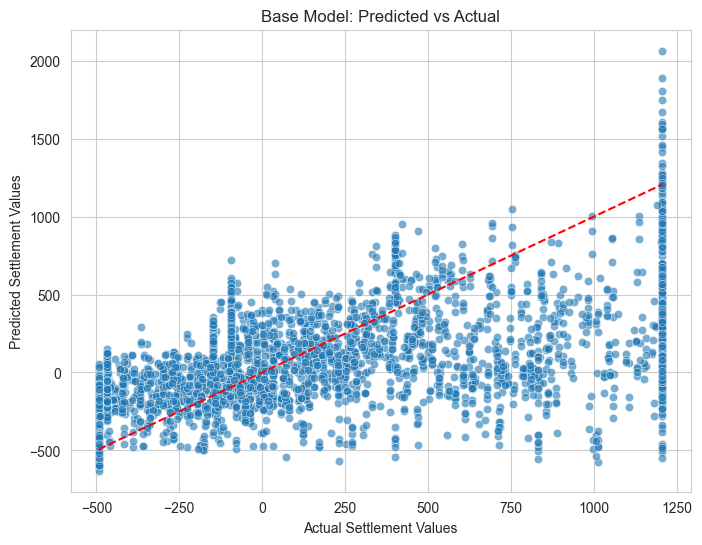

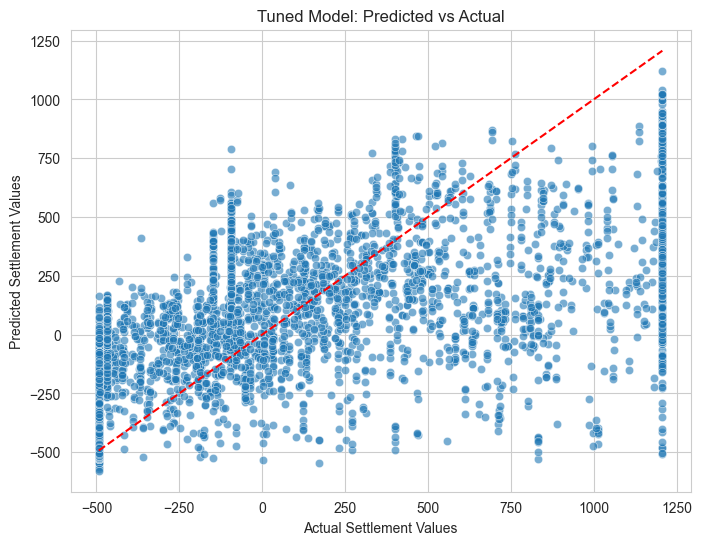

In [13]:
plot_predicted_vs_actual(base_actual, base_predicted,
                         "Base Model: Predicted vs Actual")
plot_predicted_vs_actual(tuned_actual, tuned_predicted,
                         "Tuned Model: Predicted vs Actual")